<a href="https://colab.research.google.com/github/dillonkoh89/GA-Capstone/blob/main/Capstone_Part_3_Object_Detection_Loaded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Capstone Project: Reducing Workplace Injuries in Singapore using Objection Detection Model

# Dillon Koh, DSIF-2 Singapore

## Problem Statement

Recently in 29th July 2021, a Straits Times article on Workplace inuries, fatalities can hinder business's recovery from Covid-19 pandemic was published. Manpower Minister Tan See Leng highlighted that employers and employees need to step up their workplace safety and health efforts as injuries and fatalities can hinder business recovery from the Covid-19 pandemic. He stressed that companies must continue their workplace safety and health efforts amid the pandemic, on top of the safe management measures to limit interactions at workplaces and prevent the spread of Covid-19 among workers.

In Workplace Safety and Health Report 2020 - National Statistics by Ministry of Manpower, it was mentioned that the top three causes of workpace minor injuries were:
-  (i) Slips, Trips & Falls
- (ii) Machinery Incidents; and
- (iii) Struck by Moving Objects.

These collectively accounted for 55% (5,993 cases) of the total number of workplace minor injuries in year 2020.

Hence, I would like to make use of Deep Learning to reduce the number of workplace injuries in Singapore. 

The overall end goal of my projet is to reduce the number of workplace injuries by using Object Detection Model to detect if any workers are not wearing PPE (Helmet and Vest) properly inside a PPE zone and Sounding off an alarm to alert the workers on the infringement using real time monitoring by cameras. However, the scope of my GA capstone will only cover the Object Detection Model aspect.

## Target Audence 
Various Stakeholders such as Worksite Contractors / Companies, Ministry of Manpower and etc

## Datasets of Images 
- Kaggle
- Google Images

# Manual Evaluation of Test Images using Trained Object Detection Model

In Part 3 of the Capstone Project, I will be evaluating the bounding boxes predicted by the trained object detetion model based on my judgement and methodology to have an intuition on ways to improve the performance of my model. After conducting some research, I have decided on my evaluation methodology which is based on how the mean average precision (mAP) score is derived.

First, I will go through all 100 images and classify the performance of the model on each object and bounding boxes based on the following definition:

* True Positive (TP) - Classify the object detection if IoU > 0.5
* False Positive (FP) - Classify the object detection if IoU < 0.5 or Duplicated Bounding Box or 1 Bounding Box bounding 2 objects
* False Negative (FN) - When a ground truth is present in the image and model failed to detect the object, or Wrong classification predicted
* True Negative (TN) - TN is every part of the image where we did not predict an object. This metrics is not useful for object detection, hence we ignore TN.

Based on the above definitions and methodology, the Precision and Recall scores of 0.973 and 0.782 are achieved respectively. The reason for a lower recall score is because of 102 False Negatives were observed. The confusion matrix is shown below:

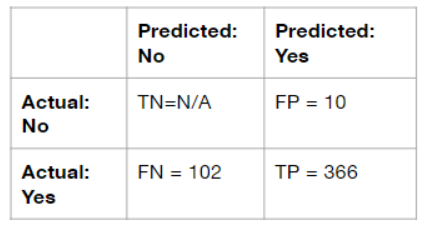

After going through 100 test images, I have also come up with a summary of the error analysis and I have also provided my reasons behind the errors commited by the the trained model -

* Resolution of images are quite bad in general which could have resulted in the model to not be able to predict several objects
* I have trained my model using 800+ images which may not be sufficient and training with more images would likely lea to my model to perform better 
* False Negative Analysis - Fails to detect the following objects:
Helmet - 40%; Person - 35%; Safety Vest - 25%
> - Possible Reasons - Insufficient images for various angles, positions of the objects. Example, a person wearing at helmet and tilting his head at 45 degrees angle, certain part of the object is blocked 
* False Positive Analysis - 1 Bounding Box tend to group 2 identical objects together
>- Possible Reasons - For some images, the Bounding Box was drawn to overlap several objects due to the object being close to each other and some object overlap other objects too.

Considering my evaluation results and the mAP score obtained from Part 2 Notebook, I believed that the performance of my object detection model is quite good and require minor fine tuning before it can be deployed to actual worksite for trial.

# Video Processing using Trained Object Detection Model

At this current stage, I have achieved 50% of overall end goal which I would like to achieve from this Capstone Project. The second part of the goal is Sounding off an alarm to alert the workers on the infringement using real time monitoring by cameras. As deploying the model on real time camera feed is not possible as I do not have access to a camera system. I will do a mock up of this by running my object detection model on a video instead and I have uploaded the video into my git repo too. 

Based on the predicted bounding boxes drawn by my model, I believed additional work is still required to improve the performance of the model. This will be covered in the last section - Future Works.

# Future Works

In this section, I will be elaborating the key points and aspects to achieve my overall end goal (which goes beyond the scope of my Capstone Project) and tackle the problem statement. It is very important to have an accurate object detection model. Hence the following steps are my proposal to deploy it in operation:


## Understanding each client's needs and requirements
- The accuracy of the model depends on several factors and is unique to different clients and hence the training of objection detection model can further be fine tuned based on the client's requirements and situation
> - Resolution and quality of the camera feed - To train the model with images of the similar resolution of the camera feed
> - Location and type of the cameras - to better understand the position, angle and etc of the objects.
> - Helmets, safety vests and Uniforms of the company such as covered overall which also function as safety vest. To train the model with these images
- Discuss with the client on how would they like the model to be deployed and the platform to view the results i.e. web browser or mobile app to view the camera feeds with the object detection model running on the camera feeds
- Providing a complete solution by integrating the object detection model, camera system and sensory system (to identify the PPE zone), alarm system with a control system (using a simple controller if possible) to monitor and trigger an alarm when any infringement is detected.

## Improving the performance of the Object Detection Model
- Training the model with more images of the client's requirements and situation
- Using image augmentation tool to augment the images such as rotation, flipping, introducing noise to provide more of such images when training the model to get a more robust model
- Consistent Drawing of the Bounding Box when annotating the images

## Proof of Concept/Trial
A small scale deployment of the end product can be put on trial and the results can be evaluated after a month. Once the client is satisified and confident of the model, we can then proceed to deploy it on a wider scale or full operation depending on the client's decision.

# References
- https://www.mom.gov.sg/-/media/mom/documents/safety-health/reports-stats/wsh-national-statistics/wsh-national-stats-2020.pdf
- https://www.straitstimes.com/singapore/jobs/workplace-injuries-fatalities-can-hinder-business-recovery-from-covid-19-pandemic-tan
- https://www.kaggle.com/johnsyin97/hardhat-and-safety-vest-image-for-object-detection
- https://amaarora.github.io/2021/01/11/efficientdet.html
- https://amaarora.github.io/2020/08/13/efficientnet.html
- https://blog.paperspace.com/mean-average-precision/
- https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52
- https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_video.py
- https://dzone.com/articles/how-to-use-google-colaboratory-for-video-processin
- https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi
- https://www.tensorflow.org/lite/tutorials/model_maker_object_detection
- https://arxiv.org/abs/1911.09070
- https://github.com/tzutalin/labelImg
- https://cocodataset.org/#detection-eval
- https://www.tensorflow.org/lite/tutorials/model_maker_object_detection
- https://www.tensorflow.org/lite/performance/post_training_quantization

In [ ]:
!pip install -q tensorflow==2.4.3

     |████████████████████████████████| 394.5 MB 387 bytes/s 
     |████████████████████████████████| 2.9 MB 38.1 MB/s 
     |████████████████████████████████| 462 kB 51.8 MB/s 
     |████████████████████████████████| 3.8 MB 36.4 MB/s 


In [ ]:
# Importing the libraries
import numpy as np
import os
import cv2
from PIL import Image
import zipfile
import os
import tensorflow as tf

assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
# This cell is using the saved model and datasets from google drive
#mount drive
#from google.colab import drive
#drive.mount('/content/drive/')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
# !ln -s /content/drive/My\ Drive/ /mydrive

#list contents in your drive
# !ls /mydrive

# Downloading the images

In [ ]:
# downloading zipped datasets from dropbox
!wget https://www.dropbox.com/s/fxmoldrklrfhtui/TFlite.zip

--2021-12-11 07:26:55--  https://www.dropbox.com/s/fxmoldrklrfhtui/TFlite.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fxmoldrklrfhtui/TFlite.zip [following]
--2021-12-11 07:26:55--  https://www.dropbox.com/s/raw/fxmoldrklrfhtui/TFlite.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbefddd8c4ffa951262a97a506f.dl.dropboxusercontent.com/cd/0/inline/BbqgJm7egH3g5YzgyOgbuozd8dAVR5UC2mwqGO7s0cKl-XiQ14DNy6nDbfDcb8KdeJl1jQYpCAjTfj5KfpBBjeRcJWkMZy2p_iMLg28hIBA1NnZKDKBKeb2NhJNN-4BA2Rl71qYJKV9rNx4Kl9loO0Fi/file# [following]
--2021-12-11 07:26:55--  https://ucbefddd8c4ffa951262a97a506f.dl.dropboxusercontent.com/cd/0/inline/BbqgJm7egH3g5YzgyOgbuozd8dAVR5UC2mwqGO7s0cKl-XiQ14DNy6nDbfDcb8KdeJl1jQYpCAjTfj5KfpBBjeRcJWkMZy2p

In [ ]:
#extracting the files in the downloaded classification.zip file
zip_ref = zipfile.ZipFile("TFlite.zip")
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
%cd TFlite/
# Walk through the "full" data directory and list number of files
for dirpath, dirnames, filenames in os.walk("full"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

/content/TFlite
There are 3 directories and 0 images in 'full'.
There are 2 directories and 0 images in 'full/test'.
There are 0 directories and 100 images in 'full/test/annotations'.
There are 0 directories and 101 images in 'full/test/images'.
There are 2 directories and 0 images in 'full/train'.
There are 0 directories and 881 images in 'full/train/annotations'.
There are 0 directories and 881 images in 'full/train/images'.
There are 2 directories and 0 images in 'full/val'.
There are 0 directories and 232 images in 'full/val/annotations'.
There are 0 directories and 232 images in 'full/val/images'.


# Image Processing using Object Detection Model on Test Images

In [ ]:
# Read the label.txt
with open('/content/TFlite/colab_models/tflite1/labels.txt', 'rb') as file:
    lines = []
    for line in file:
        lines.append(line.rstrip().decode())

# Load the labels into a list
# classes = ['helmet', 'person', 'safety vest']
classes = lines
print(classes)

['helmet', 'person', 'safety vest']


In [ ]:
# opening the model.tflite file which was modelled in the previous notebook
with open('/content/TFlite/colab_models/tflite3/model.tflite', 'rb') as fid:
    tflite_model = fid.read()

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [ ]:
# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Return the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  # Run the inference
  interpreter.invoke()

  # Get all outputs from the model
  scores = get_output_tensor(interpreter, 0)
  boxes = get_output_tensor(interpreter, 1)
  count = int(get_output_tensor(interpreter, 2))
  classes = get_output_tensor(interpreter, 3)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8, results

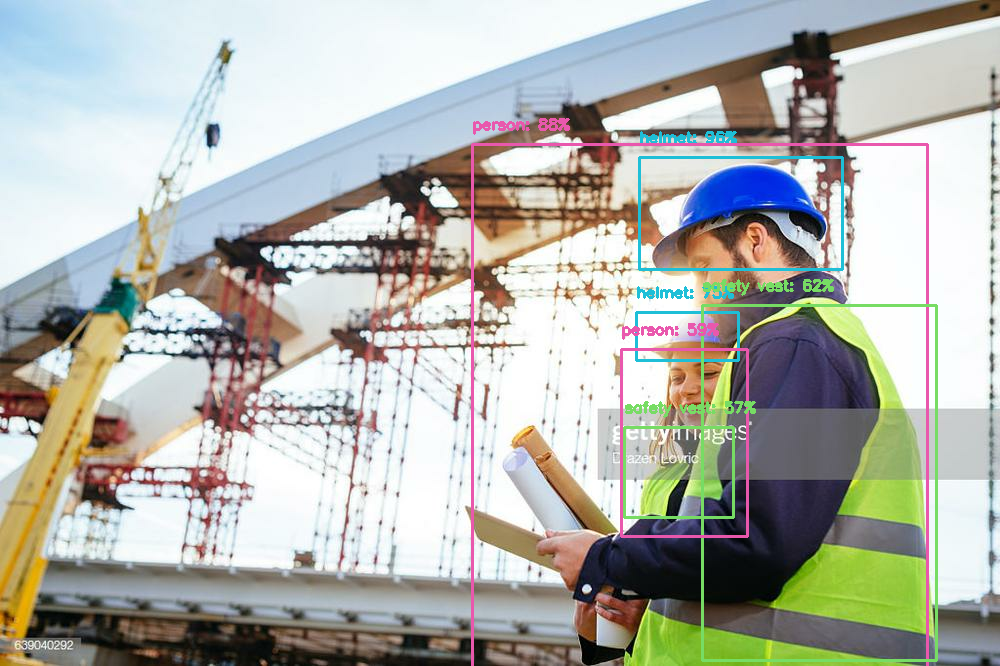

In [ ]:
# Input the image directory and location
INPUT_IMAGE = '/content/TFlite/full/test/images/pos_242.jpg'
# Setting the minimum detection threshold
DETECTION_THRESHOLD = 0.5

#This script will resize an image (somepic.jpg) using PIL (Python Imaging Library) to a width of 300 pixels and a height proportional to the new width. It does this by determining what percentage 300 pixels is of the original width (img.size[0]) and then multiplying the original height (img.size[1]) by that percentage. Change "basewidth" to any other number to change the default width of your images.
basewidth = 1000
img = Image.open(INPUT_IMAGE)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('/content/TFlite/full/test/images/temp_resize.jpg')

temp_file = '/content/TFlite/full/test/images/temp_resize.jpg'

# Run inference and draw detection result on the local copy of the original file
detection_result_image, results = run_odt_and_draw_results(
    temp_file, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


In [ ]:
# printing the bounding boxes locations
print(results)

[{'bounding_box': array([0.23665419, 0.63932437, 0.40427658, 0.8424179 ], dtype=float32), 'class_id': 0.0, 'score': 0.95703125}, {'bounding_box': array([0.21718058, 0.47203523, 1.0067761 , 0.92796487], dtype=float32), 'class_id': 1.0, 'score': 0.87890625}, {'bounding_box': array([0.469844 , 0.6367266, 0.5415522, 0.7382734], dtype=float32), 'class_id': 0.0, 'score': 0.75}, {'bounding_box': array([0.45810926, 0.70271003, 0.9909915 , 0.9362109 ], dtype=float32), 'class_id': 2.0, 'score': 0.625}, {'bounding_box': array([0.52517664, 0.6216921 , 0.8055848 , 0.7475465 ], dtype=float32), 'class_id': 1.0, 'score': 0.58984375}, {'bounding_box': array([0.6425282 , 0.62419754, 0.77675855, 0.73366266], dtype=float32), 'class_id': 2.0, 'score': 0.57421875}]


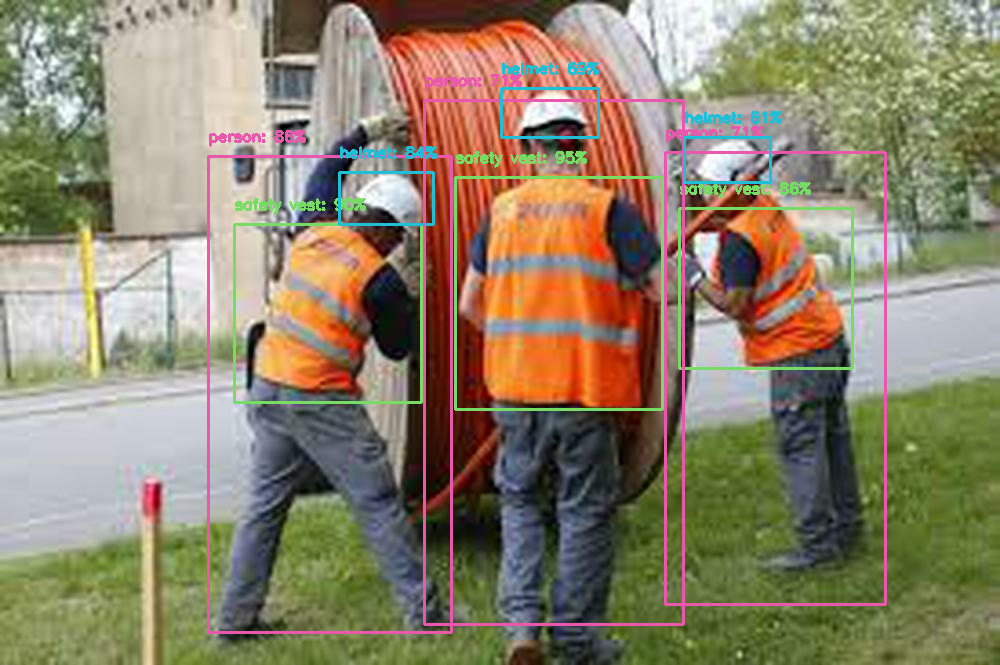

In [ ]:
# Input the image directory and location
INPUT_IMAGE = '/content/TFlite/full/test/images/pos_3424.jpg'
# Setting the minimum detection threshold
DETECTION_THRESHOLD = 0.5

#This script will resize an image (somepic.jpg) using PIL (Python Imaging Library) to a width of 300 pixels and a height proportional to the new width. It does this by determining what percentage 300 pixels is of the original width (img.size[0]) and then multiplying the original height (img.size[1]) by that percentage. Change "basewidth" to any other number to change the default width of your images.
basewidth = 1000
img = Image.open(INPUT_IMAGE)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('/content/TFlite/full/test/images/temp_resize.jpg')

temp_file = '/content/TFlite/full/test/images/temp_resize.jpg'

# Run inference and draw detection result on the local copy of the original file
detection_result_image, results = run_odt_and_draw_results(
    temp_file, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

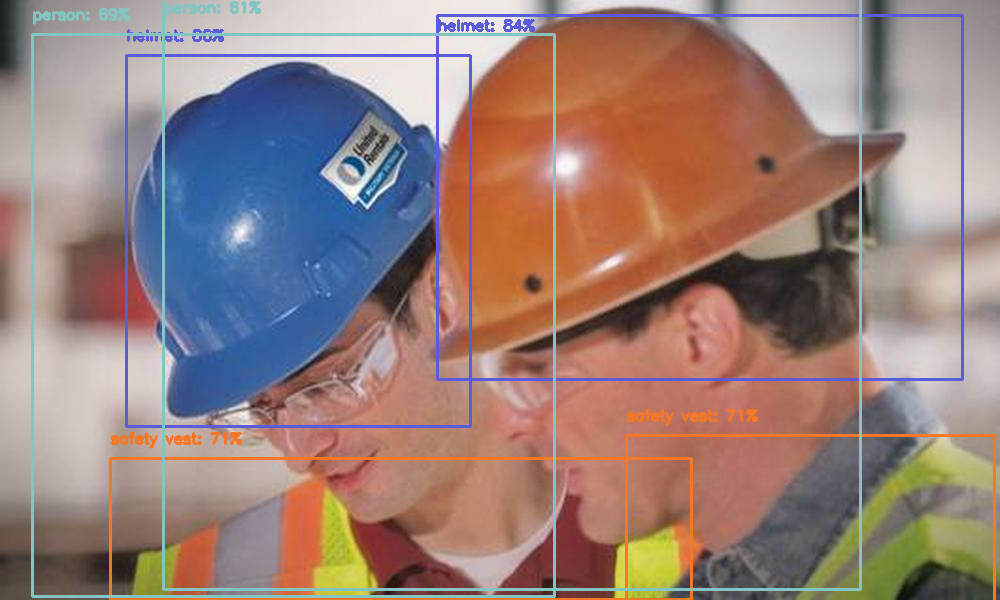

In [ ]:
# Input the image directory and location
INPUT_IMAGE = '/content/TFlite/full/test/images/pos_125.jpg'
# Setting the minimum detection threshold
DETECTION_THRESHOLD = 0.5

#This script will resize an image (somepic.jpg) using PIL (Python Imaging Library) to a width of 300 pixels and a height proportional to the new width. It does this by determining what percentage 300 pixels is of the original width (img.size[0]) and then multiplying the original height (img.size[1]) by that percentage. Change "basewidth" to any other number to change the default width of your images.
basewidth = 1000
img = Image.open(INPUT_IMAGE)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('/content/TFlite/full/test/images/temp_resize.jpg')

temp_file = '/content/TFlite/full/test/images/temp_resize.jpg'

# Run inference and draw detection result on the local copy of the original file
detection_result_image, results = run_odt_and_draw_results(
    temp_file, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

# Video Processing using Object Detection Model

The second part of the overall end goal is Sounding off an alarm to alert the workers on the infringement using real time monitoring by cameras. As deploying the model on real time camera feed is not possible as I do not have access to a camera system. I have done a mock up of this by running my object detection model on a video instead. The completed video is uploaded to the github repo. 

In addition I have also upload a python notebook to my github repo too and downloading the file - *TFLite_detection_video.py* and running this notebook can allow one to do the object detection on other videos. 

To run the python notebook, you are required to store the following in the same directory folder. 

- tflite model
- class label map in txt format
- video

To run the python notebook, simply type the following code in a jupyter noteboo

!python TFLite_detection_video.py --modeldir=< folder directory with all the files >

Please input the file names in the above code for the above files as well as the minimum confidence threshold for displayed detected objects. To break the video window, just press the key 'q'.


Also, to deploy this object detection model to real time camera video feed, I can easily make some adjustments to this python notebook by changing the input to the selected camera instead an input video.